## 1. Generate training simulation images according to csv file

<br />
This feature will generate images from csv files based on your evaluation model and will provide you with images of the selected track for referance and comparison.

Run this code if it's your first time using this notebook:

                                  pip install deepracer-utils

#### Follow these steps step by step
1. Log in to deepracer console
2. Select your training models on the left
3. Choose your model
4. Select the teaining mode
5. Download your evaluation logs
6. Unzip your log files

#### Run the code in the following unit and select your csv file and track name.

###  <span style="color: green;">What is training mode and what is evaluation mode? </span>


#### In AWS DeepRacer, training mode and evaluation mode are two separate phases for training and evaluating the performance of the reinforcement learning agent. Here are the main differences:

#### Training mode：
1. In training mode, the agent (DeepRacer vehicle) interacts with the environment (the track) and learns a strategy. It optimizes this strategy by trying different actions and observing the results.
2. The training mode involves a balance between exploration and exploitation. Exploration is when an agent tries a new action to find the best possible strategy, while exploitation is when an agent chooses an action based on a learned strategy.
3. The goal of the training mode is for the agent to learn and find the optimal strategy through as much trial and error as possible. The performance of the agent may be erratic during training.

#### Evaluation mode：
1. The evaluation mode is conducted after the training is complete. In the evaluation mode, the agent performs actions in the environment (on the track) based on strategies learned during the training phase.
2. In evaluation mode, the agent focuses on exploiting learned strategies rather than continuing to explore new actions. As a result, there is little or no exploration under the assessment model.
3. The goal of the evaluation pattern is to measure the agent's performance against the learned strategy. It helps you see if the training process works and how the agent performs in real life.

In conclusion, the training model focuses on the process of learning strategies, while the evaluation model focuses on the performance of learned strategies in practice. In the context of DeepRacer, the training mode is used to optimize the agent's behavior, while the evaluation mode is used to measure its performance on the track.




#### Run the code and download the necessary libraries

In [3]:
from deepracer.tracks import TrackIO, Track

from deepracer.logs import \
    AnalysisUtils as au, \
    SimulationLogsIO as slio, \
    EvaluationUtils as eu, \
    PlottingUtils as pu

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

#### Upload your log files, and copy the name of the log files into the 'logs'

In [4]:
logs = [['evaluation-20230315234311-W79tkqQnQzCHEbz6M-B04w-robomaker.log', '20230315234311']]

In [5]:
 # Loads all the logs from the above time range 
bulk = slio.load_a_list_of_logs(logs)

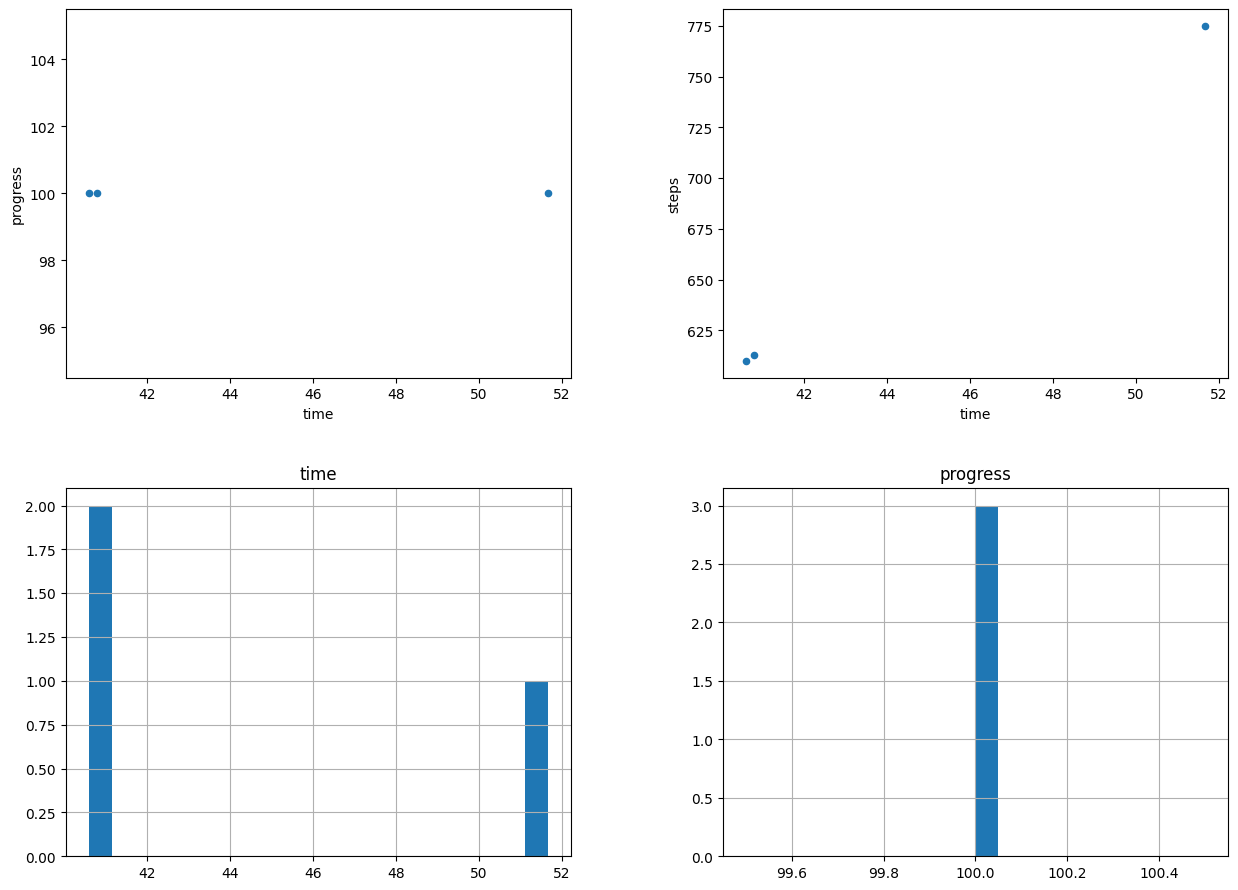

<Figure size 640x480 with 0 Axes>

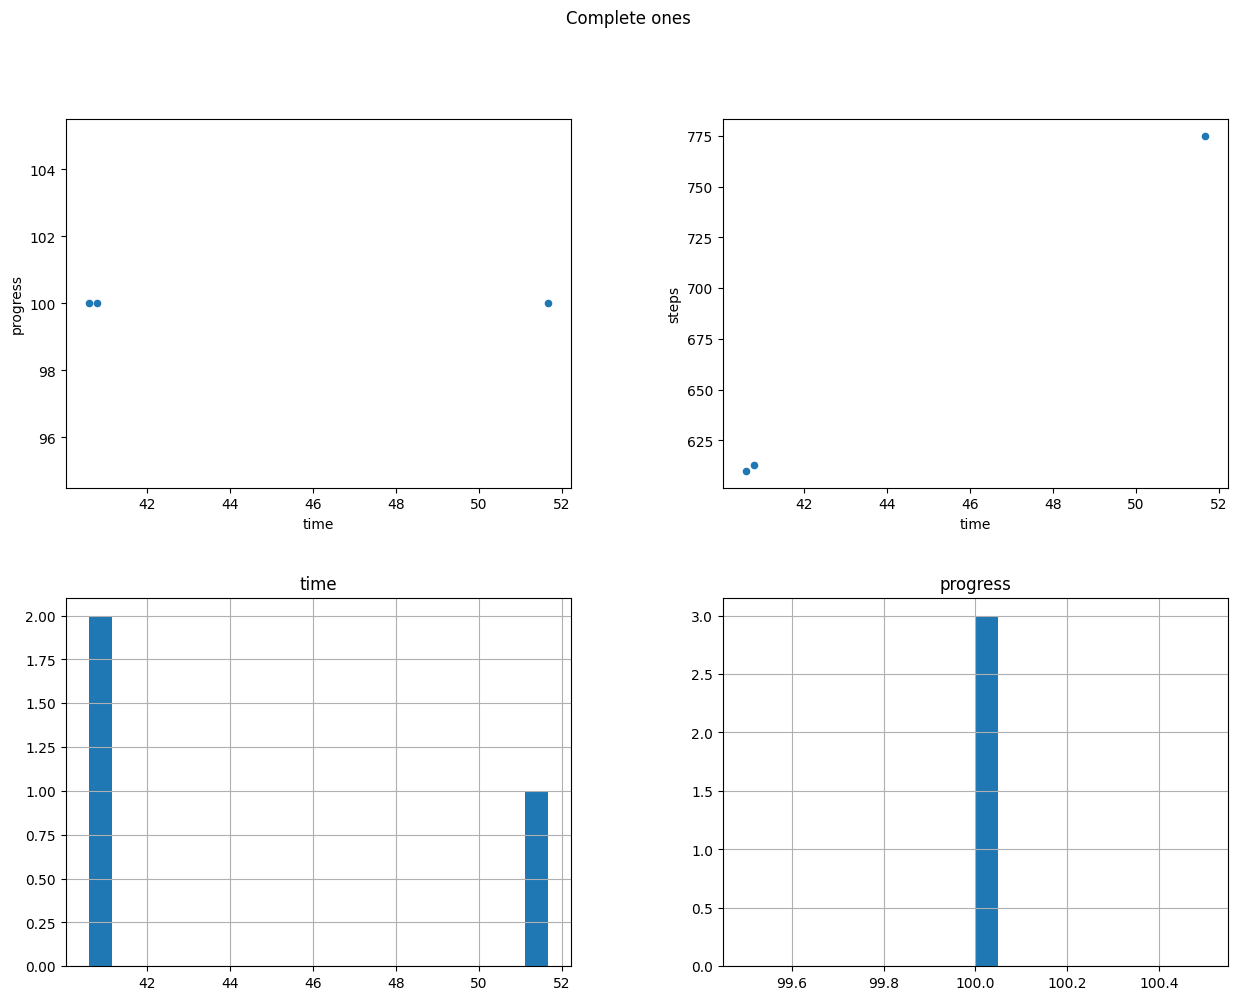

<Figure size 640x480 with 0 Axes>

In [57]:
simulation_agg = au.simulation_agg(bulk, 'stream', is_eval=True)
complete_ones = simulation_agg[simulation_agg['progress']==100]

au.scatter_aggregates(simulation_agg, is_eval=True)
if complete_ones.shape[0] > 0:
    au.scatter_aggregates(complete_ones, "Complete ones", is_eval=True)

In [58]:
# View fifteen most progressed attempts
simulation_agg.nlargest(15, 'progress')

,stream,episode,steps,start_at,progress,time,dist,speed,crashed,off_track,time_if_complete,complete
0,20230315234311,0,775,0,100.0,51.672,35.330404,0.731858,0,4,51.672,1
1,20230315234311,1,610,0,100.0,40.602,31.291110,0.698852,0,0,40.602,1
2,20230315234311,2,613,0,100.0,40.803,31.256211,0.691403,0,0,40.803,1


In [59]:
# View fifteen fastest complete laps
complete_ones.nsmallest(15, 'time')

,stream,episode,steps,start_at,progress,time,dist,speed,crashed,off_track,time_if_complete,complete
1,20230315234311,1,610,0,100.0,40.602,31.291110,0.698852,0,0,40.602,1
2,20230315234311,2,613,0,100.0,40.803,31.256211,0.691403,0,0,40.803,1
0,20230315234311,0,775,0,100.0,51.672,35.330404,0.731858,0,4,51.672,1


In [6]:
import os
from IPython.display import display
import ipywidgets as widgets
from deepracer.tracks import TrackIO, Track

track_dir = "./maps"
# show all the npy file
npy_files = [f for f in os.listdir(track_dir) if f.endswith('.npy')]

# Create a drop-down menu
dropdown = widgets.Dropdown(
    options=npy_files,
    description='Track files:',
)

# Create a global variable to hold the selected file name and Track object
global track
track = None
tu = TrackIO()

# Creates a function that takes a file name as an argument and loads the file
def load_track(file_name):
    global track
    track = tu.load_track(os.path.join(track_dir, file_name))
    
# Create an interactive interface
widgets.interact(load_track, file_name=dropdown)

interactive(children=(Dropdown(description='Track files:', options=('2022_april_open.npy', '2022_april_pro.npy…

<function __main__.load_track(file_name)>

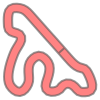

In [7]:
track.road_poly

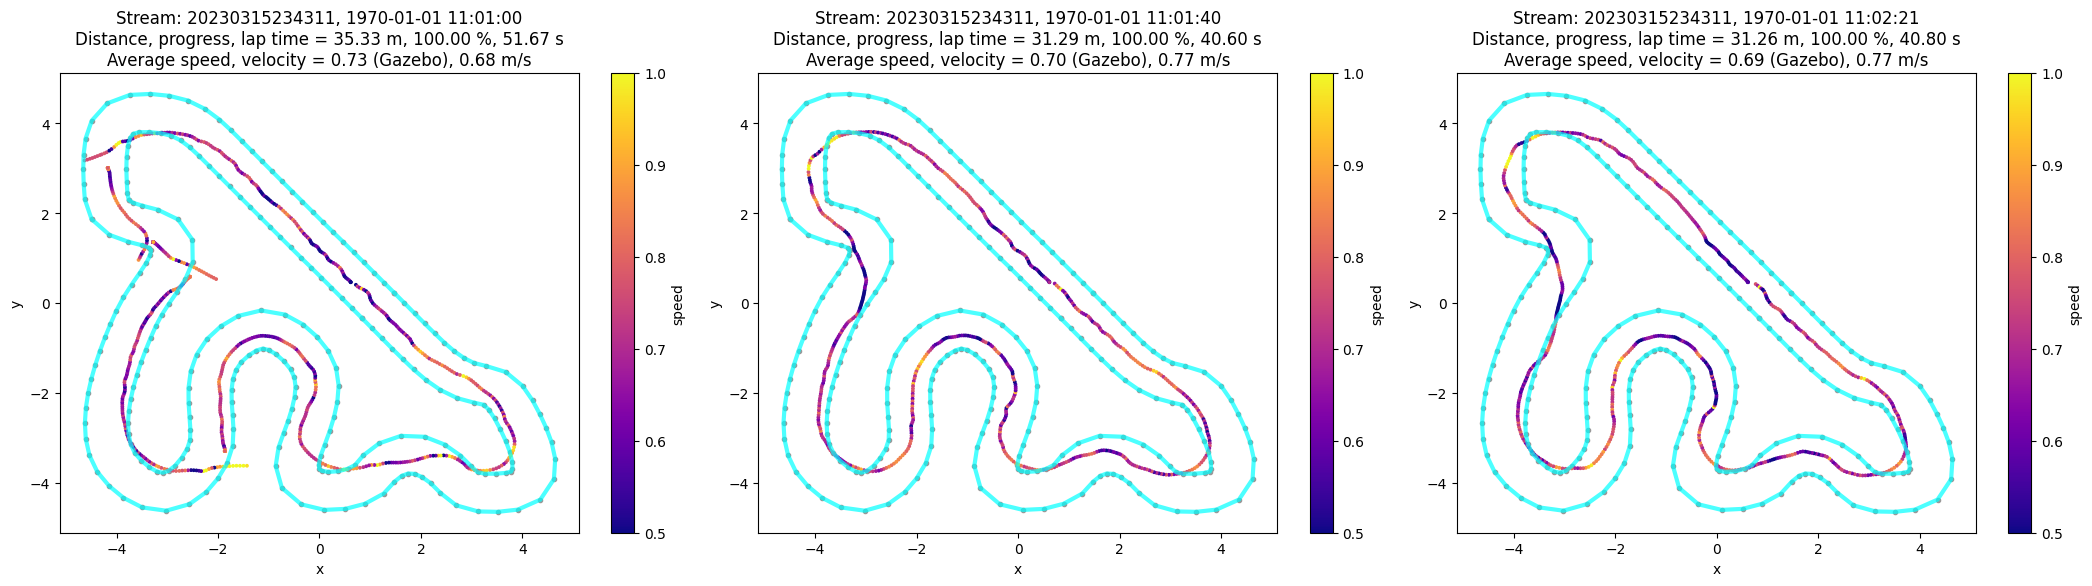

<Figure size 640x480 with 0 Axes>

In [8]:
pu.plot_evaluations(bulk, track)

In [13]:
# Load a single lap
lap_df = bulk[(bulk['episode']==0) & (bulk['stream']==logs[0][1])]

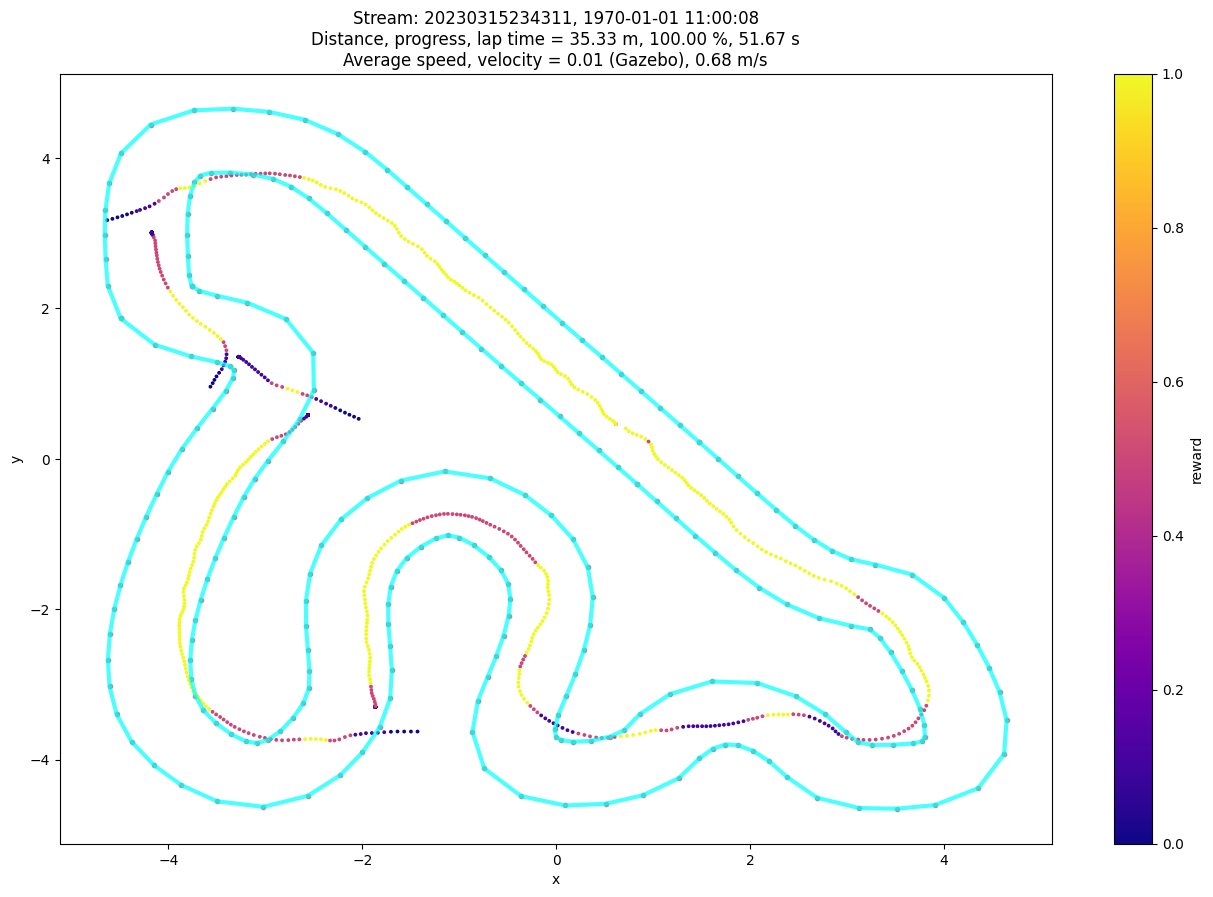

<Figure size 640x480 with 0 Axes>

In [14]:
lap_df.loc[:,'distance']=((lap_df['x'].shift(1)-lap_df['x']) ** 2 + (lap_df['y'].shift(1)-lap_df['y']) ** 2) ** 0.5
lap_df.loc[:,'time']=lap_df['tstamp'].astype(float)-lap_df['tstamp'].shift(1).astype(float)
lap_df.loc[:,'speed']=lap_df['distance']/(100*lap_df['time'])
lap_df.loc[:,'acceleration']=(lap_df['distance']-lap_df['distance'].shift(1))/lap_df['time']
lap_df.loc[:,'progress_delta']=lap_df['progress'].astype(float)-lap_df['progress'].shift(1).astype(float)
lap_df.loc[:,'progress_delta_per_time']=lap_df['progress_delta']/lap_df['time']

pu.plot_grid_world(lap_df, track, graphed_value='reward')